## Imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from scipy.stats import chi2_contingency
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import ComplementNB
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold

## Initializing Data

In [2]:
driver_dtypes = {'Local Case Number': "string", "Num Motorist Involved": "string"}
df = pd.read_csv("../Datasets/prepared_data.csv", dtype=driver_dtypes)

target1 = ["Injury Severity Remapped"]
target1_feats = ["Vehicle Body Type", "Incident Hit/Run", "Vehicle Make", "Collision Type", "Driver At Fault", "NonTraffic", 
                 "Vehicle Movement", "Traffic Analysis Zone", "Speed Limit", "First Harmful Event", "Vehicle Second Impact Location",
                 "Number of Lanes", "Vehicle First Impact Location", "Policy Name", "Lane Number", "Route Type", "Hour Range",
                 "Month"]

target1_df = df[target1+target1_feats]

## Checking Distribution

In [3]:
target1_df[target1].value_counts(normalize=True)

Injury Severity Remapped
NO APPARENT INJURY          0.820143
POSSIBLE OR MINOR INJURY    0.170756
SERIOUS OR FATAL INJURY     0.009101
dtype: float64

In [4]:
target1_df.shape

(171414, 19)

In [5]:
target1_df = target1_df.dropna()
target1_df[target1].value_counts(normalize=True)

Injury Severity Remapped
NO APPARENT INJURY          0.810285
POSSIBLE OR MINOR INJURY    0.180473
SERIOUS OR FATAL INJURY     0.009242
dtype: float64

In [6]:
target1_df.reset_index(inplace=True, drop=True)
target1_df.shape

(155813, 19)

In [7]:
def test_normality(distro):
    stat, p = stats.shapiro(distro)
    alpha = 0.05

    if p > alpha:
        print("p =",p)
        print("Normal Distribution (Fail to Reject Null Hypothesis)")
    else:
        print("Not Normal Distribution (Reject Null Hypothesis)")

In [8]:
test_normality(target1_df[target1].value_counts(normalize=True).tolist())

p = 0.3903374969959259
Normal Distribution (Fail to Reject Null Hypothesis)


## Test for Multicolinearity

In [9]:
corr = pd.DataFrame(index=target1_feats+target1, columns=target1_feats+target1)

In [10]:
def get_cramers_v(idx, col, n):
    contingency_table = pd.crosstab(idx, col)
    chi2, _, _, _ = chi2_contingency(contingency_table)
    feature_shape = contingency_table.shape[0]
    target_shape = contingency_table.shape[1]
    cramers_v = np.sqrt(chi2 / (n * min(feature_shape-1, target_shape-1)))
    return cramers_v

In [11]:
for idx in corr.index:
    for col in corr.columns:
        corr.at[idx, col] = get_cramers_v(target1_df[idx], target1_df[col], target1_df.shape[0])

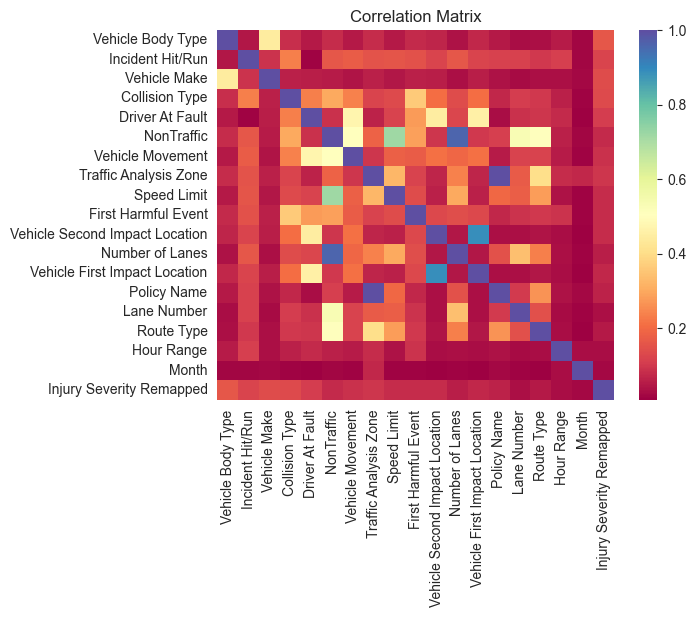

In [67]:
sns.heatmap(corr.astype(float), cmap=sns.color_palette("Spectral", as_cmap=True))
plt.title("Correlation Matrix")
plt.show()

To start I am going to remove a few features due to multicolinearity. 

**Traffic Analysis Zone** has a perfect correlation with Policy name. This make sense due to they were both derived from the same supplementary data set. While Traffic analysis zone does have a better correlation with the target variable than policy name, it also has 10 time the amount of features. Thus to reduce spatial complexity in the model, for the time being it makes the most sense to use policy name instead of traffic analysis zone.

**Number of Lanes** and Nontraffic also almost have a perfect correlation. NonTraffic being binary, and having a higher correlation with the target variable than Number of Lanes, makes it the feature that should be kept. Thus, Number of Lanes will be dropped from the dataset.

**Vehicle Second Impact Location** also has a high correlation with Vehicle First Impact Location. Both variables have a similar correlation with the target so the second is what will be dropped as it comes after the first.

## Variable Encoding

In [13]:
target1_df = target1_df.drop(columns=["Traffic Analysis Zone", "Number of Lanes", "Vehicle Second Impact Location"])

In [14]:
binary_feats = ["Incident Hit/Run", "Driver At Fault", "NonTraffic"]
ordinal_feats = ["Speed Limit", "Lane Number", "Vehicle First Impact Location", "Hour Range", "Month"]
nominal_feats = ["Vehicle Body Type", "Vehicle Make", "Collision Type", "Vehicle Movement", "First Harmful Event",
                "Policy Name", "Route Type"]

In [15]:
model_df = pd.get_dummies(target1_df, columns=nominal_feats)

In [16]:
for col in binary_feats + ordinal_feats:
    model_df[col] = model_df[col].astype('category').cat.codes

## Classifiers
#### Parameter Selections

In [17]:
def gridSearch(clf, params, df, n_rows, score='f1_weighted', is_y_np=False):
    df = df[: n_rows]
    
    X_n = df.drop(columns=["Injury Severity Remapped"])
    y_n = df["Injury Severity Remapped"]
    y_np = df["Injury Severity Remapped"].values
    y_np = LabelEncoder().fit_transform(y_np)
    
    grid_search = GridSearchCV(clf, params, cv=10, scoring=score)
    
    if is_y_np:
        grid_search.fit(X_n, y_np)
    else:
        grid_search.fit(X_n, y_n)
    
    return grid_search

In [18]:
%%time
rf_params = {
    'n_estimators': [50, 100, 200, 300, 500],
    'max_depth': [None, 5, 10, 15, 20, 25],
    'min_samples_split': [2, 5, 10],
    'class_weight': ['balanced']
}

gs_rf = gridSearch(RandomForestClassifier(), rf_params, model_df, int(model_df.shape[0]*.10)) 
print("Best Random Forest parameters found: ", gs_rf.best_params_)
print("Best Random Forest f1_weighted found: ", gs_rf.best_score_)

Best Random Forest parameters found:  {'class_weight': 'balanced', 'max_depth': None, 'min_samples_split': 10, 'n_estimators': 100}
Best Random Forest f1_weighted found:  0.7575096788214324
CPU times: total: 43min 14s
Wall time: 48min 11s


In [19]:
%%time 
bernNB_params = {'fit_prior': [True, False],
                        'alpha': [0.1, 0.25, 0.5, 0.75, 1, 1.5, 2, 5, 10, 15, 20, 25, 50, 100]}
gs_bernNB = gridSearch(BernoulliNB(), bernNB_params, model_df.loc[:, ~model_df.columns.isin(ordinal_feats)], model_df.shape[0])
print("Best BernoulliNB parameters found: ", gs_bernNB.best_params_)
print("Best BernoulliNB f1_weighted found: ", gs_bernNB.best_score_)

Best BernoulliNB parameters found:  {'alpha': 25, 'fit_prior': True}
Best BernoulliNB f1_weighted found:  0.7492952999909017
CPU times: total: 4min 8s
Wall time: 4min 45s


In [20]:
%%time
compNB_params = {'norm': [True, False],
                 'alpha': [0.1, 0.25, 0.5, 0.75, 1, 1.5, 2, 5, 10, 15, 20, 25, 50, 100]}
gs_compNB = gridSearch(ComplementNB(), compNB_params, model_df, model_df.shape[0])
print("Best ComplementNB parameters found: ", gs_compNB.best_params_)
print("Best ComplementNB f1_weighted found: ", gs_compNB.best_score_)

Best ComplementNB parameters found:  {'alpha': 50, 'norm': True}
Best ComplementNB f1_weighted found:  0.7489156872382164
CPU times: total: 3min 43s
Wall time: 4min 12s


In [21]:
%%time
xgb_params = {'booster': ['gbtree'],
              'eta': [0.01, 0.05, 0.1],
              'max_depth': [3, 6, 9],
              'min_child_weight': [0.25, 0.5, 1, 5],
              'lambda': [0.1, 1.0, 10.0],
              'alpha': [0.0, 0.1, 0.5],
              'objective': ['multi:softmax'],
              'num_class': [4],
              'tree_method':['hist']}

gs_xgb = gridSearch(xgb.XGBClassifier(), xgb_params, model_df, int(model_df.shape[0]*.10), is_y_np=True)
print("Best XGBoost parameters found: ", gs_xgb.best_params_)
print("Best XGBoost f1_weighted found: ", gs_xgb.best_score_)

Best XGBoost parameters found:  {'alpha': 0.5, 'booster': 'gbtree', 'eta': 0.1, 'lambda': 0.1, 'max_depth': 9, 'min_child_weight': 1, 'num_class': 4, 'objective': 'multi:softmax', 'tree_method': 'hist'}
Best XGBoost f1_weighted found:  0.7438776182670981
CPU times: total: 10h 58min 4s
Wall time: 58min 57s


#### Model Evaluations with Selected Parameters

In [50]:
classifiers = ["Random Forest", "BernoulliNB", "ComplementNB", "XGBoost"]
accs = []
f1s = []

In [23]:
def plot_cm(df, title):
    plt.figure(figsize=(10, 6))
    sns.heatmap(df, cmap = 'viridis', annot=True, fmt="d", square=True, linewidths=.5)
    plt.xlabel("Predicted Values", fontsize=10)
    plt.ylabel("Actual Values", fontsize=10)
    plt.xticks(wrap=True, fontsize=7, rotation=0)
    plt.yticks(wrap=True, fontsize=7)
    plt.title(title)
    plt.show()

In [24]:
def kfold_eval(clf, X, y):
    acc = []
    f1_weighted = []
    cm = []
    kf = StratifiedKFold(n_splits=10, shuffle=False)
    for train, test in kf.split(X, y):
        clf.fit(X.iloc[train], y[train])
        y_pred = clf.predict(X.iloc[test])
        class_names = sorted(set(y[test]) | set(y_pred))
        acc += [accuracy_score(y[test], y_pred)]
        f1_weighted += [f1_score(y[test], y_pred, average='weighted')]
        cm += [pd.DataFrame(confusion_matrix(y[test], y_pred, labels=class_names), index=class_names, columns=class_names)]
    return acc, f1_weighted, cm

In [25]:
X = model_df.drop(columns=["Injury Severity Remapped"])
y = model_df["Injury Severity Remapped"]

X_np = model_df.drop(columns=["Injury Severity Remapped"]).values
y_np = model_df["Injury Severity Remapped"].values
y_np = LabelEncoder().fit_transform(y_np)

In [51]:
%%time
rf = RandomForestClassifier(**gs_rf.best_params_)

acc, f1_weighted, cm = kfold_eval(rf, X, y)
accs.append(np.mean(acc)); f1s.append(np.mean(f1_weighted))
print(f'Random Forest CV accuracy={np.mean(acc):.3f} {np.std(acc):.3f}')
print(f'Random Forest CV f1_weighted={np.mean(f1_weighted):.3f} {np.std(f1_weighted):.3f}')

Random Forest CV accuracy=0.771 0.006
Random Forest CV f1_weighted=0.755 0.004
CPU times: total: 4min 46s
Wall time: 5min 18s


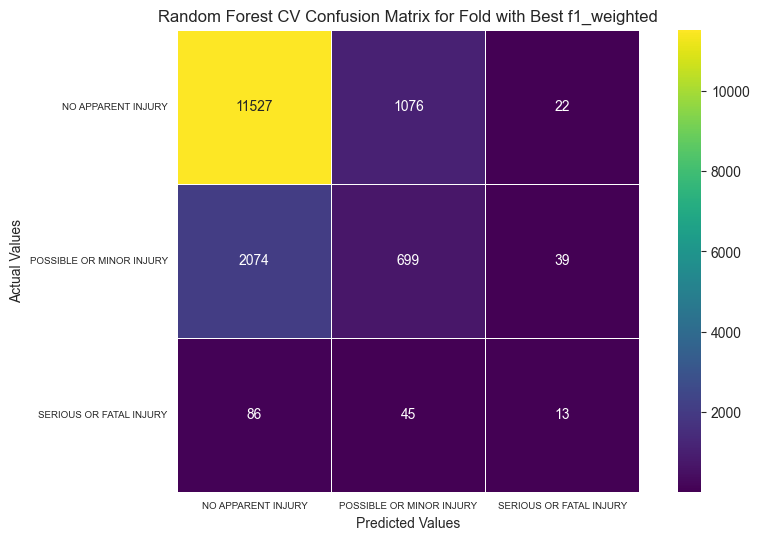

In [52]:
plot_cm(cm[f1_weighted.index(max(f1_weighted))], 'Random Forest CV Confusion Matrix for Fold with Best f1_weighted')

In [53]:
%%time
bernNB = BernoulliNB(**gs_bernNB.best_params_)

acc, f1_weighted, cm = kfold_eval(bernNB, X, y)
accs.append(np.mean(acc)); f1s.append(np.mean(f1_weighted))
print(f'BernoulliNB CV accuracy={np.mean(acc):.3f} {np.std(acc):.3f}')
print(f'BernoulliNB CV f1_weighted={np.mean(f1_weighted):.3f} {np.std(f1_weighted):.3f}')

BernoulliNB CV accuracy=0.793 0.003
BernoulliNB CV f1_weighted=0.750 0.003
CPU times: total: 10 s
Wall time: 11 s


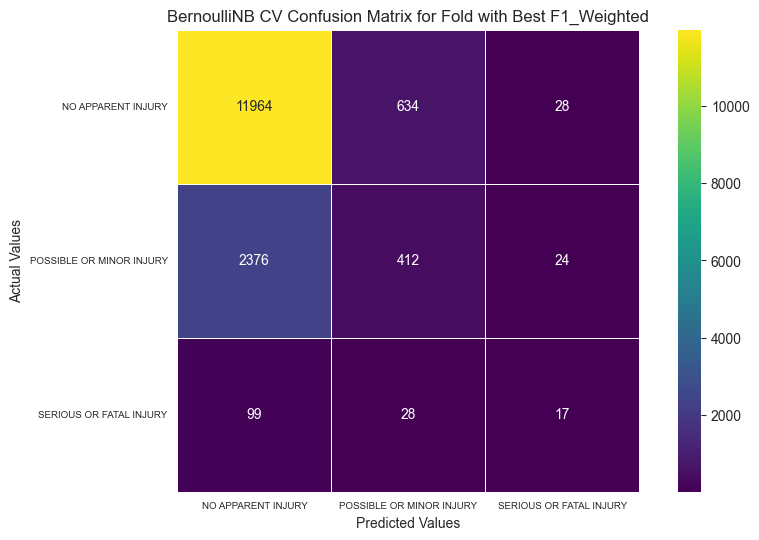

In [54]:
plot_cm(cm[f1_weighted.index(max(f1_weighted))], 'BernoulliNB CV Confusion Matrix for Fold with Best F1_Weighted')

In [55]:
%%time
compNB = ComplementNB(**gs_compNB.best_params_)

acc, f1_weighted, cm = kfold_eval(compNB, X, y)
accs.append(np.mean(acc)); f1s.append(np.mean(f1_weighted))
print(f'ComplementNB CV accuracy={np.mean(acc):.3f} {np.std(acc):.3f}')
print(f'ComplementNB CV f1_weighted={np.mean(f1_weighted):.3f} {np.std(f1_weighted):.3f}')

ComplementNB CV accuracy=0.759 0.006
ComplementNB CV f1_weighted=0.749 0.004
CPU times: total: 8.78 s
Wall time: 9.77 s


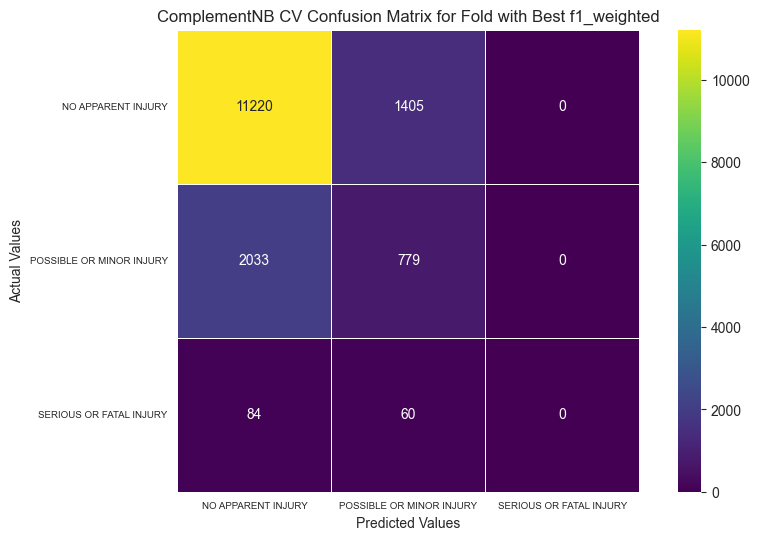

In [56]:
plot_cm(cm[f1_weighted.index(max(f1_weighted))], 'ComplementNB CV Confusion Matrix for Fold with Best f1_weighted')

In [57]:
%%time
xgb_clf = xgb.XGBClassifier(**gs_xgb.best_params_)

acc, f1_weighted, cm = kfold_eval(xgb_clf, X, y_np)
accs.append(np.mean(acc)); f1s.append(np.mean(f1_weighted))
print(f'XGBoost CV accuracy={np.mean(acc):.3f} {np.std(acc):.3f}')
print(f'XGBoost CV f1_weighted={np.mean(f1_weighted):.3f} {np.std(f1_weighted):.3f}')

XGBoost CV accuracy=0.812 0.001
XGBoost CV f1_weighted=0.736 0.002
CPU times: total: 11min 3s
Wall time: 1min 1s


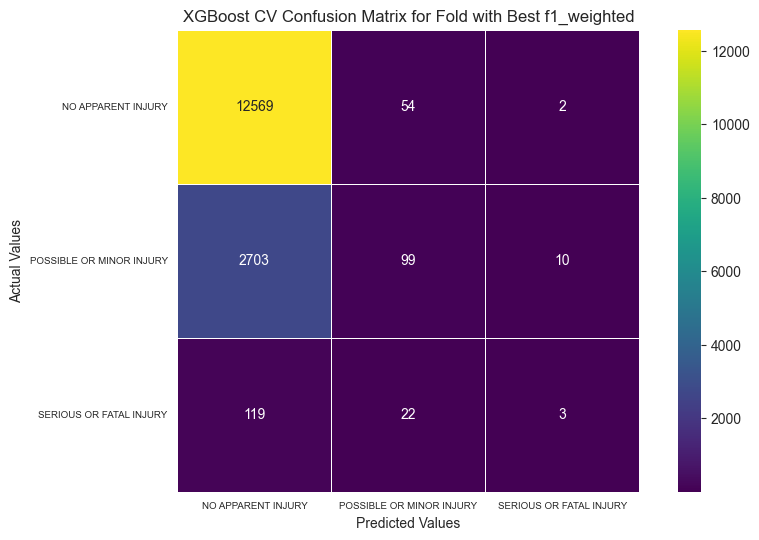

In [66]:
best_cm = cm[f1_weighted.index(max(f1_weighted))]
best_cm.index = target1_df['Injury Severity Remapped'].unique().tolist()
best_cm.columns = target1_df['Injury Severity Remapped'].unique().tolist()
plot_cm(best_cm, 'XGBoost CV Confusion Matrix for Fold with Best f1_weighted')

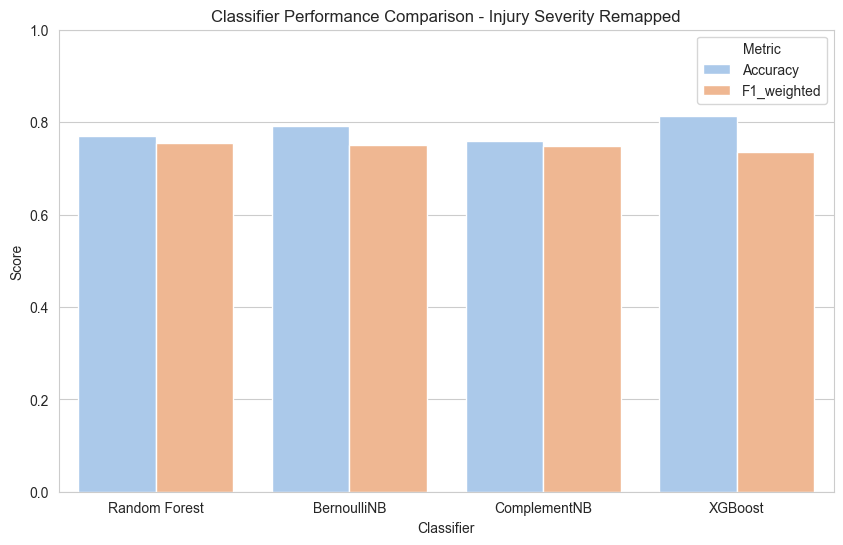

In [60]:
sns.set_style("whitegrid")
sns.set_palette("pastel")

data = {
    'Classifier': classifiers,
    'Accuracy': accs,
    'F1_weighted': f1s
}

results = pd.DataFrame(data)
results = pd.melt(results, id_vars='Classifier', var_name='Metric', value_name='Value')

plt.figure(figsize=(10, 6))
sns.barplot(data=results, x='Classifier', y='Value', hue='Metric')
plt.title('Classifier Performance Comparison - Injury Severity Remapped')
plt.ylabel('Score')
plt.xlabel('Classifier')
plt.ylim(0, 1)
plt.legend(title='Metric')
plt.show()